In [1]:
import gurobipy as gp
import numpy as np
import pandas as pd
from scipy import stats


from gurobi_implementation import GurobiSolution
from data_market import Seller, MarketOperator, Market, Buyer
from p2p_gurobi import Agents, FirstStageMarket
from tso_gurobi import TSOModel, TSOOptimization

In [2]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import seaborn as sns
sns.set()

In [3]:
np.random.seed(0)

## Data Market

In [4]:
#reading data from csv

probabilities = pd.read_csv('df_probabilities_100.csv')
probabilities = probabilities['0'].to_list()

g_res = pd.read_csv('df_g_res_100.csv')
generation = g_res.drop('Unnamed: 0', axis = 1).loc[0].to_list()

In [5]:
agent_keys = [661, 1642, 2335, 2361, 2818, 3039, 3456, 3538, 4031, 4373, 4767, 5746, 6139, 7536, 7719, 7800, 7901, 7951, 8156, 8386, 8565, 9019, 9160, 9922, 9278]

dataframe_dict = dict()
for key in agent_keys:
    dataframe_dict.update({key : pd.read_csv('/Users/ishilov/Documents/risk_paper/risk_paper/data/df_{}.csv'.format(key))})

community_size = len(dataframe_dict)

for key in agent_keys:
    cond_min = (dataframe_dict[key]['demand'].quantile(0.01) <= dataframe_dict[key]['demand'])
    cond_max = (dataframe_dict[key]['demand'] <= dataframe_dict[key]['demand'].quantile(0.99))
    dataframe_dict[key] = dataframe_dict[key][cond_min & cond_max]

In [6]:
def distribution_build(sample_size, agent_keys):
    res = {}
    
    for key in agent_keys:
        probas_demand, values_demand = np.histogram(dataframe_dict[key]['demand'], bins = sample_size, density=True)
        probas_demand = probas_demand / probas_demand.sum()
        distribution_demand = stats.rv_histogram([probas_demand, values_demand])

        if 'solar' in dataframe_dict[key].columns:
            data = dataframe_dict[key][dataframe_dict[key]['solar'] >= 0]['solar']
            probas_solar, values_solar = np.histogram(data, bins = sample_size, density=True)
            probas_solar = probas_solar / probas_solar.sum()
            distribution_solar = stats.rv_histogram([probas_solar, values_solar])

        res.update({key : 
                    {'probas_demand' : probas_demand,
                    'values_demand' : values_demand,
                    'probas_solar' : probas_solar,
                    'values_solar' : values_solar,
                    'distribution_demand' : distribution_demand,
                    'distribution_solar' : distribution_solar}})

    return res 

In [7]:
distributions = distribution_build(100, agent_keys)
distributions_solar = {key : distributions[key]['distribution_solar'] for key in agent_keys}

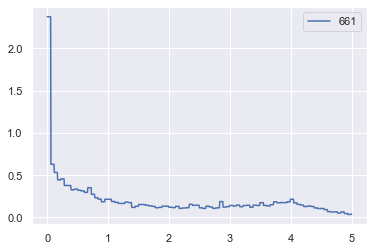

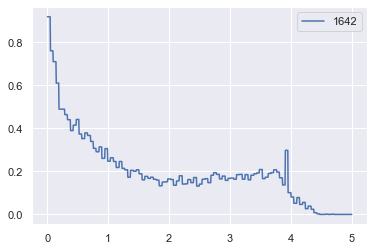

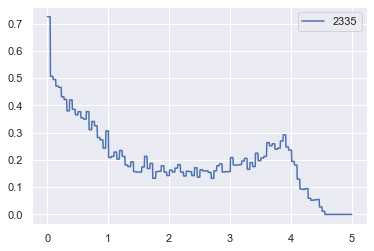

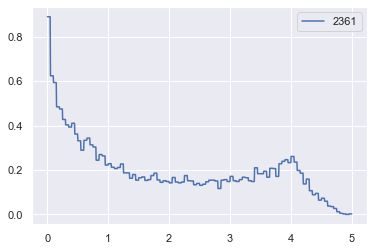

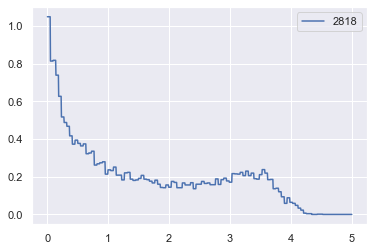

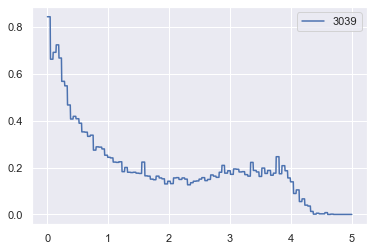

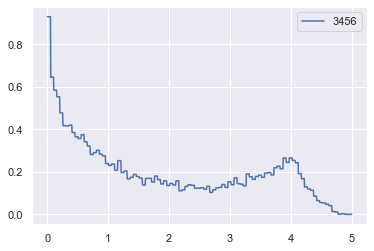

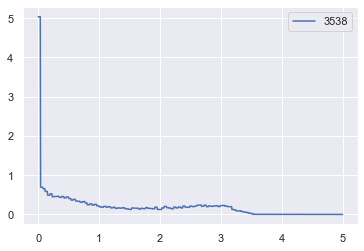

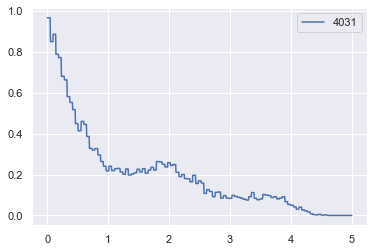

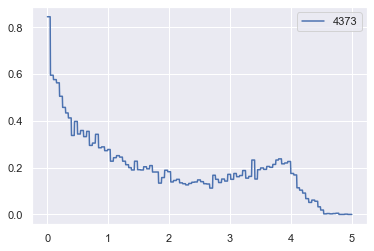

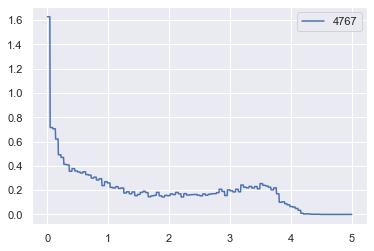

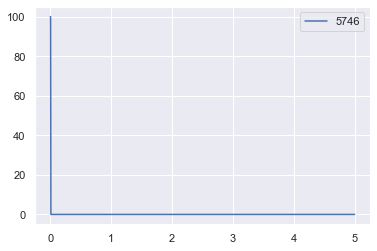

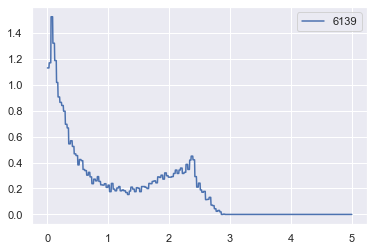

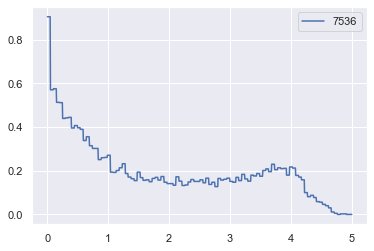

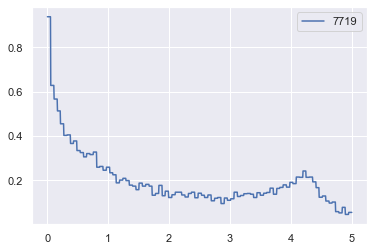

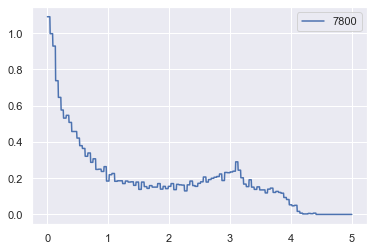

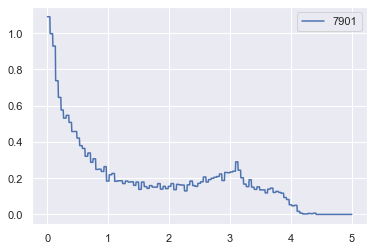

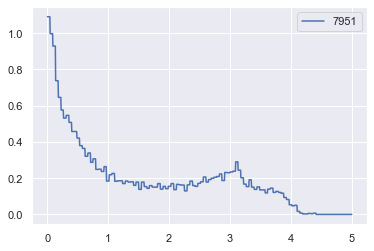

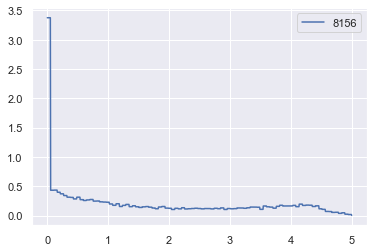

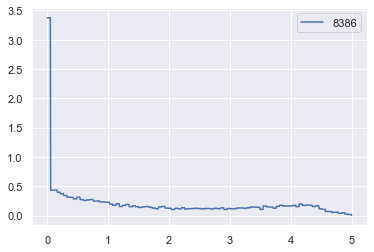

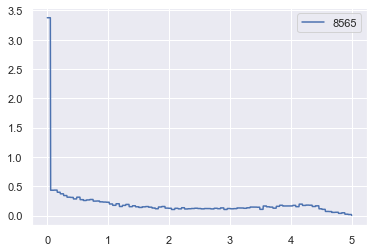

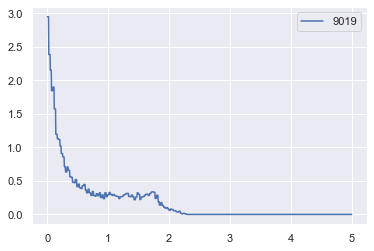

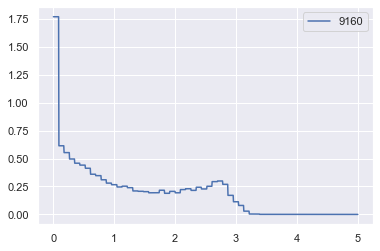

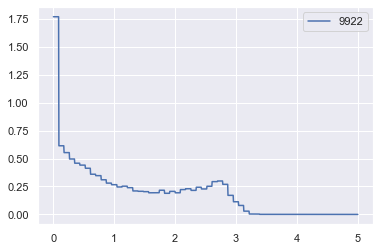

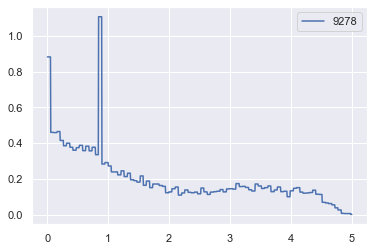

In [8]:
support = np.linspace(0,5, 1000)

for key in agent_keys:
    plt.plot(support, distributions_solar[key].pdf(support), label = key)
    plt.legend()
    plt.show()

## Peer-to-peer electricity market

In [9]:
def text_to_adj_matrix(matrix_path):
    res = []
    with open(matrix_path) as file:
        for s in file:
            string = ''.join(s.strip().strip(',').split(', '))
            lst_temp = [int(sym) for sym in string]

            res.append(lst_temp)

    return res

connection_matrix = text_to_adj_matrix('./matrices/matrix_2.txt')


In [10]:
trading_costs = [[np.random.uniform(0,1) if i!=j else 0 for i in range(community_size)] for j in range(community_size)]

In [11]:
trading_costs = [[0,
  0.5488135039273248,
  0.7151893663724195,
  0.6027633760716439,
  0.5448831829968969,
  0.4236547993389047,
  0.6458941130666561,
  0.4375872112626925,
  0.8917730007820798,
  0.9636627605010293,
  0.3834415188257777,
  0.7917250380826646,
  0.5288949197529045,
  0.5680445610939323,
  0.925596638292661,
  0.07103605819788694,
  0.08712929970154071,
  0.02021839744032572,
  0.832619845547938,
  0.7781567509498505,
  0.8700121482468192,
  0.978618342232764,
  0.7991585642167236,
  0.46147936225293185,
  0.7805291762864555],
 [0.11827442586893322,
  0,
  0.6399210213275238,
  0.1433532874090464,
  0.9446689170495839,
  0.5218483217500717,
  0.4146619399905236,
  0.26455561210462697,
  0.7742336894342167,
  0.45615033221654855,
  0.5684339488686485,
  0.018789800436355142,
  0.6176354970758771,
  0.6120957227224214,
  0.6169339968747569,
  0.9437480785146242,
  0.6818202991034834,
  0.359507900573786,
  0.43703195379934145,
  0.6976311959272649,
  0.06022547162926983,
  0.6667667154456677,
  0.6706378696181594,
  0.2103825610738409,
  0.1289262976548533],
 [0.31542835092418386,
  0.3637107709426226,
  0,
  0.5701967704178796,
  0.43860151346232035,
  0.9883738380592262,
  0.10204481074802807,
  0.2088767560948347,
  0.16130951788499626,
  0.6531083254653984,
  0.2532916025397821,
  0.4663107728563063,
  0.24442559200160274,
  0.15896958364551972,
  0.11037514116430513,
  0.6563295894652734,
  0.1381829513486138,
  0.1965823616800535,
  0.3687251706609641,
  0.8209932298479351,
  0.09710127579306127,
  0.8379449074988039,
  0.09609840789396307,
  0.9764594650133958,
  0.4686512016477016],
 [0.9767610881903371,
  0.604845519745046,
  0.7392635793983017,
  0,
  0.039187792254320675,
  0.2828069625764096,
  0.1201965612131689,
  0.29614019752214493,
  0.11872771895424405,
  0.317983179393976,
  0.41426299451466997,
  0.06414749634878436,
  0.6924721193700198,
  0.5666014542065752,
  0.2653894909394454,
  0.5232480534666997,
  0.09394051075844168,
  0.5759464955561793,
  0.9292961975762141,
  0.31856895245132366,
  0.6674103799636817,
  0.13179786240439217,
  0.7163272041185655,
  0.2894060929472011,
  0.18319136200711683],
 [0.5865129348100832,
  0.020107546187493552,
  0.8289400292173631,
  0.004695476192547066,
  0,
  0.6778165367962301,
  0.27000797319216485,
  0.7351940221225949,
  0.9621885451174382,
  0.24875314351995803,
  0.5761573344178369,
  0.592041931271839,
  0.5722519057908734,
  0.2230816326406183,
  0.952749011516985,
  0.44712537861762736,
  0.8464086724711278,
  0.6994792753175043,
  0.29743695085513366,
  0.8137978197024772,
  0.39650574084698464,
  0.8811031971111616,
  0.5812728726358587,
  0.8817353618548528,
  0.6925315900777659],
 [0.7252542798196405,
  0.5013243819267023,
  0.9560836347232239,
  0.6439901992296374,
  0.4238550485581797,
  0,
  0.6063932141279244,
  0.019193198309333526,
  0.30157481667454933,
  0.660173537492685,
  0.29007760721044407,
  0.6180154289988415,
  0.42876870094576613,
  0.13547406422245023,
  0.29828232595603077,
  0.5699649107012649,
  0.5908727612481732,
  0.5743252488495788,
  0.6532008198571336,
  0.6521032700016889,
  0.43141843543397396,
  0.896546595851063,
  0.36756187004789653,
  0.4358649252656268,
  0.8919233550156721],
 [0.8061939890460857,
  0.7038885835403663,
  0.10022688731230112,
  0.9194826137446735,
  0.7142412995491114,
  0.9988470065678665,
  0,
  0.14944830465799375,
  0.8681260573682142,
  0.16249293467637482,
  0.6155595642838442,
  0.12381998284944151,
  0.8480082293222344,
  0.8073189587250107,
  0.5691007386145933,
  0.40718329722599966,
  0.06916699545513805,
  0.6974287731445636,
  0.45354268267806885,
  0.7220555994703479,
  0.8663823259286292,
  0.9755215050028858,
  0.855803342392611,
  0.011714084185001972,
  0.3599780644783639],
 [0.729990562424058,
  0.17162967726144052,
  0.5210366062041293,
  0.05433798833925363,
  0.19999652489640007,
  0.01852179446061397,
  0.7936977033574206,
  0,
  0.22392468806038013,
  0.3453516806969027,
  0.9280812934655909,
  0.7044144019235328,
  0.03183892953130785,
  0.16469415649791275,
  0.6214784014997635,
  0.5772285886041676,
  0.23789282137450862,
  0.9342139979247938,
  0.613965955965896,
  0.5356328030249583,
  0.589909976354571,
  0.7301220295167696,
  0.31194499547960186,
  0.3982210622160919,
  0.20984374897512215],
 [0.18619300588033616,
  0.9443723899839336,
  0.7395507950492876,
  0.4904588086175671,
  0.22741462797332324,
  0.25435648177039294,
  0.05802916032387562,
  0.4344166255581208,
  0,
  0.3117958819941026,
  0.6963434888154595,
  0.3777518392924809,
  0.1796036775596348,
  0.02467872839133123,
  0.06724963146324858,
  0.6793927734985673,
  0.4536968445560453,
  0.5365792111087222,
  0.8966712930403421,
  0.9903389473967044,
  0.21689698439847394,
  0.6630782031001008,
  0.26332237673715064,
  0.02065099946572868,
  0.7583786538361414],
 [0.32001715082246784,
  0.38346389417189797,
  0.5883171135536057,
  0.8310484552361904,
  0.6289818435911487,
  0.8726506554473953,
  0.27354203481563577,
  0.7980468339125637,
  0.1856359443059522,
  0,
  0.9527916569719446,
  0.6874882763878153,
  0.21550767711355845,
  0.9473705904889242,
  0.7308558067701578,
  0.25394164259502583,
  0.21331197736748198,
  0.5182007139306632,
  0.025662718054531575,
  0.2074700754411094,
  0.42468546875150626,
  0.37416998033422555,
  0.4635754243648107,
  0.2776287062947319,
  0.5867843464581688],
 [0.8638556059232314,
  0.11753185596203308,
  0.5173791071541142,
  0.1320681063451533,
  0.7168596811925937,
  0.39605970280729375,
  0.565421311858509,
  0.18327983621407862,
  0.14484775934337724,
  0.48805628064895457,
  0,
  0.3556127378499556,
  0.940431945252813,
  0.7653252538069653,
  0.7486636198505473,
  0.9037197397459334,
  0.08342243544201855,
  0.5521924699224066,
  0.5844760689557689,
  0.961936378547229,
  0.29214752679254885,
  0.24082877991544682,
  0.10029394226549782,
  0.016429629591474204,
  0.9295293167921905],
 [0.66991654659091,
  0.7851529120231378,
  0.2817301057539491,
  0.5864101661863267,
  0.06395526612098112,
  0.4856275959346229,
  0.9774951397444468,
  0.8765052453165908,
  0.33815895183684563,
  0.9615701545414985,
  0.2317016264712045,
  0,
  0.9493188224156814,
  0.9413777047064986,
  0.7992025873523917,
  0.6304479368667911,
  0.874287966624947,
  0.2930202845077967,
  0.8489435553129182,
  0.6178766919175238,
  0.01323685775889949,
  0.34723351793221957,
  0.14814086094816503,
  0.9818293898182532,
  0.47837030703998806],
 [0.4973913654986627,
  0.6394725163987236,
  0.3685846061296175,
  0.13690027168559893,
  0.8221177331942455,
  0.18984791190275796,
  0.511318982546456,
  0.22431702897473926,
  0.09784448449403405,
  0.8621915174216833,
  0.9729194890231303,
  0.9608346580630002,
  0,
  0.906555499221179,
  0.7740473326986388,
  0.3331451520286419,
  0.08110138998799676,
  0.40724117141380733,
  0.23223414217094274,
  0.13248763475798297,
  0.05342718178682526,
  0.7255943642105788,
  0.011427458625031028,
  0.7705807485027762,
  0.14694664540037505],
 [0.07952208258675575,
  0.08960303423860538,
  0.6720478073539145,
  0.24536720985284477,
  0.42053946668009845,
  0.5573687913239169,
  0.8605511738287938,
  0.7270442627113283,
  0.27032790523871464,
  0.1314827992911276,
  0.05537432042119794,
  0.3015986344809425,
  0.26211814923967824,
  0,
  0.45614056680047965,
  0.6832813355476804,
  0.6956254456388572,
  0.28351884658216664,
  0.3799269559001205,
  0.18115096173690304,
  0.7885455123065187,
  0.0568480764332403,
  0.6969972417249873,
  0.7786953959411034,
  0.7774075618487531],
 [0.25942256434535493,
  0.37381313793256143,
  0.587599635196389,
  0.272821902424467,
  0.3708527992178887,
  0.19705428018563964,
  0.4598558837560074,
  0.044612301254114084,
  0.799795884570618,
  0.07695644698663273,
  0.518835148831526,
  0.3068100995451961,
  0.5775429488313755,
  0.9594333408334251,
  0,
  0.6455702444560039,
  0.03536243575549092,
  0.43040243950806123,
  0.5100168523182502,
  0.536177494703452,
  0.6813925106038379,
  0.2775960977317661,
  0.1288605654663202,
  0.39267567654709434,
  0.9564057227959488],
 [0.18713089175084474,
  0.903983954928237,
  0.5438059500773263,
  0.4569114216457658,
  0.8820414102298896,
  0.45860396176858587,
  0.7241676366115433,
  0.399025321703102,
  0.9040443929009577,
  0.6900250201912274,
  0.6996220542505167,
  0.3277204015571189,
  0.7567786427368892,
  0.6360610554471413,
  0.24002027337970955,
  0,
  0.16053882248525642,
  0.7963914745173317,
  0.9591666030352225,
  0.45813882726004285,
  0.5909841653236849,
  0.8577226441935546,
  0.45722345335385706,
  0.9518744768327362,
  0.5757511620448724],
 [0.820767120701315,
  0.9088437184127384,
  0.8155238187685688,
  0.15941446344895593,
  0.6288984390617004,
  0.3984342586196771,
  0.0627129520233457,
  0.42403225188984195,
  0.2586840668894077,
  0.8490383084285108,
  0.03330462654669619,
  0.9589827218634736,
  0.3553688484719296,
  0.3567068904025429,
  0.01632850268370789,
  0.18523232523618394,
  0,
  0.4012595008036087,
  0.9292914173027139,
  0.09961493022127133,
  0.9453015334790795,
  0.8694885305466322,
  0.4541623969075518,
  0.32670088176826007,
  0.23274412927905685],
 [0.6144647064768743,
  0.03307459147550562,
  0.015606064446828216,
  0.42879572249823783,
  0.0680740739747202,
  0.2519409882460929,
  0.22116091534608384,
  0.2531911937228519,
  0.13105523121525775,
  0.01203622289765427,
  0.11548429713874808,
  0.6184802595127479,
  0.9742562128180503,
  0.9903450015608939,
  0.4090540953730616,
  0.16295442604660537,
  0.6387617573665293,
  0,
  0.49030534654873714,
  0.9894097772844315,
  0.0653042071517802,
  0.7832344383138131,
  0.2883984973314939,
  0.241418620076574,
  0.662504571532676],
 [0.24606318499096447,
  0.6658591175591877,
  0.5173085172022888,
  0.4240889884358493,
  0.554687808661419,
  0.28705151991962974,
  0.7065747062729789,
  0.414856869333564,
  0.36054556048589226,
  0.8286569145557378,
  0.9249669119531921,
  0.046007310887296926,
  0.2326269928297655,
  0.34851936949256324,
  0.8149664793702474,
  0.9854914276432976,
  0.9689717046703518,
  0.9049483455499269,
  0,
  0.2965562650640299,
  0.9920112434144741,
  0.2494200410564512,
  0.1059061548822322,
  0.9509526110553941,
  0.2334202554680963],
 [0.6897682650777505,
  0.05835635898058866,
  0.7307090991274762,
  0.8817202123338397,
  0.2724368954659625,
  0.37905689607742854,
  0.3742961833209161,
  0.7487882575401331,
  0.23780724253903884,
  0.171853099047643,
  0.4492916486877381,
  0.3044684073773195,
  0.8391891222586524,
  0.23774182601563876,
  0.5023894574892614,
  0.9425835996979304,
  0.6339976977446607,
  0.8672894054624648,
  0.9402096893547673,
  0,
  0.7507648618863519,
  0.6995750602247514,
  0.9679655666042271,
  0.9944007896476794,
  0.45182168266975964],
 [0.07086977818420837,
  0.29279403144051885,
  0.15235470568773046,
  0.4174863747960118,
  0.13128932847325603,
  0.604117804020882,
  0.3828080591578541,
  0.89538588428821,
  0.9677946717985019,
  0.5468849016694222,
  0.2748235698675966,
  0.5922304187618368,
  0.8967611582244098,
  0.4067333458357483,
  0.5520782766919708,
  0.2716527676061459,
  0.455444149450027,
  0.40171353537959864,
  0.24841346508297102,
  0.5058663838253084,
  0,
  0.3103808259798114,
  0.37303486388074747,
  0.5249704422542643,
  0.7505950229289875],
 [0.3335074657912753,
  0.9241587666207636,
  0.8623185468359024,
  0.04869029597552854,
  0.25364252425682277,
  0.4461355126592019,
  0.10462788874247408,
  0.3484759890334971,
  0.7400975256176825,
  0.6805144811428259,
  0.6223844285660048,
  0.7105284027223456,
  0.20492368695970176,
  0.3416981148647321,
  0.6762424822774629,
  0.8792347630313271,
  0.5436780538280952,
  0.2826996509455366,
  0.03023525800598259,
  0.7103368289742134,
  0.007884103508440377,
  0,
  0.3726790698209955,
  0.5305372145627818,
  0.922111461767193],
 [0.08949454503290011,
  0.4059423219682837,
  0.024313199710157773,
  0.3426109843415903,
  0.6222310588397949,
  0.2790679482285984,
  0.2097499496556351,
  0.11570323332709365,
  0.5771402440203418,
  0.695270005904686,
  0.6719571405958223,
  0.9488610207205074,
  0.0027032138935026984,
  0.647196653894036,
  0.6003922370976396,
  0.5887396099702882,
  0.9627703198402424,
  0.016871673370039697,
  0.6964824307014501,
  0.8136786497018634,
  0.5098071966215841,
  0.33396486959680916,
  0,
  0.7908401632274049,
  0.09724292563242465],
 [0.44203563772992527,
  0.5199523745708382,
  0.6939564109345475,
  0.09088573203240946,
  0.22775950153786095,
  0.41030156269012563,
  0.6232946730201306,
  0.8869607812174175,
  0.6188261682413765,
  0.13346147093493443,
  0.9805801327872824,
  0.8717857347554929,
  0.502720761145324,
  0.922347981796633,
  0.5413807937571358,
  0.9233060678891631,
  0.8298973686033432,
  0.9682864102942973,
  0.9197828107781584,
  0.03603381742856948,
  0.17477200416093996,
  0.38913467710118577,
  0.9521426972954208,
  0,
  0.3000289194759296],
 [0.16046764388760104,
  0.8863046660865599,
  0.4463944154832029,
  0.9078755943543261,
  0.16023046632014326,
  0.6611175115080995,
  0.4402637528294918,
  0.0764867690302854,
  0.6964631446525006,
  0.2473987555391537,
  0.039615522579517726,
  0.05994429824957326,
  0.06107853706678734,
  0.9077329574850395,
  0.739883917829101,
  0.8980623572137351,
  0.6725823112965214,
  0.5289399290308832,
  0.30444636434737826,
  0.9979622513286734,
  0.36218905893938935,
  0.47064894921390954,
  0.37824517492346177,
  0.9795269293354586,
  0]]

In [12]:
Kappa = [[10 if i!=j else 0 for i in range(community_size)] for j in range(community_size)]

In [13]:
demand = [8, 8, 9, 7, 8, 7, 7, 9, 9, 8, 8, 6, 9, 6, 8, 6, 7, 9, 7, 6, 8, 7, 7, 8, 6]
#demand = [2, 2, 3, 1, 2, 4, 1, 3, 3, 4, 2, 3, 1, 4, 4, 5, 1, 3, 4, 2, 5, 5, 5, 1, 4]

In [14]:
means_base_forecasts = [0.8045670270776432,
                        1.013315729602517,
                        2.0284857954454707,
                        1.7236086139928533,
                        0.9281422425924236,
                        1.5556687075573468,
                        1.242477100535213,
                        1.4571803040470759,
                        1.6742950501106706,
                        1.5738517232502214,
                        1.699506159188794,
                        0.2405423035568037,
                        1.5258808003369477,
                        1.6408779364595203,
                        2.3044433411181995,
                        2.1905783675037593,
                        1.4433559888096898,
                        0.9463246169038547,
                        2.111857347190762,
                        1.599330231524489,
                        1.925669117842285,
                        1.7530069905258472,
                        1.8120144586989713,
                        0.7283821698186553,
                        1.6283037307914494]

In [15]:
myclip_a = 0
myclip_b = 10
my_scale = 2.0



def scale_parameters(myclip_a, myclip_b, my_mean, my_std):
    a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std

    return a,b

base_forecasts = [stats.truncnorm(loc = mean, 
                                scale = my_scale, 
                                a = scale_parameters(myclip_a, myclip_b, mean, my_scale)[0], 
                                b = scale_parameters(myclip_a, myclip_b, mean, my_scale)[1]) for mean in means_base_forecasts]

#base_forecasts = [stats.uniform(loc = 0, 
#                               scale = 7) for mean in means_base_forecasts]

agents_forecasts = []
for base_forecast in base_forecasts:
    probas, values = np.histogram(base_forecast.rvs(size = 100000), bins = 100, density = True)
    probas = probas / probas.sum()
    agents_forecasts.append((probas, values))

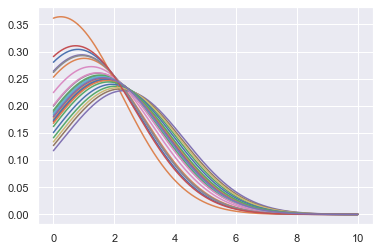

In [16]:
support = np.linspace(0,10, 1000)

for i in range(community_size):
    plt.plot(support, base_forecasts[i].pdf(support))
plt.show()

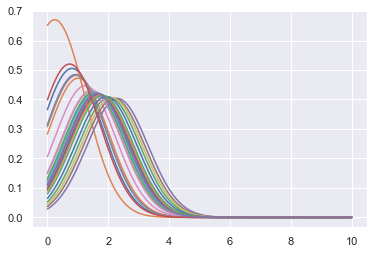

In [17]:
myclip_a = 0
myclip_b = 10
my_scale = 1



def scale_parameters(myclip_a, myclip_b, my_mean, my_std):
    a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std

    return a,b

better_forecasts = [stats.truncnorm(loc = mean, 
                                scale = my_scale, 
                                a = scale_parameters(myclip_a, myclip_b, mean, my_scale)[0], 
                                b = scale_parameters(myclip_a, myclip_b, mean, my_scale)[1]) for mean in means_base_forecasts]

#base_forecasts = [stats.uniform(loc = 0, 
#                               scale = 7) for mean in means_base_forecasts]

support = np.linspace(0,10, 1000)

for i in range(community_size):
    plt.plot(support, better_forecasts[i].pdf(support))
plt.show()

In [18]:
def second_stage_resolution(model, agents, actual_generations, price_da_buy, price_da_sell, price_rt_buy, price_rt_sell):
    second_stage_decisions = []
    actual_costs = []
    for agent in agents:
        second_stage_decision = (agent.demand 
                                - actual_generations[agent.id] 
                                - model.getVarByName(f'Agent {agent.id} day-ahead purchase').X
                                + model.getVarByName(f'Agent {agent.id} day-ahead sale').X
                                - model.getVarByName(f'Agent {agent.id} net trading').X)

        second_stage_cost = price_rt_buy * second_stage_decision if second_stage_decision > 0 else price_rt_sell * second_stage_decision

        second_stage_decisions.append(second_stage_decision)

        actual_cost = (price_da_buy * model.getVarByName(f'Agent {agent.id} day-ahead purchase').X 
                    - price_da_sell * model.getVarByName(f'Agent {agent.id} day-ahead sale').X
                    + second_stage_cost)


        actual_costs.append(actual_cost)

    return second_stage_decisions, actual_costs

In [19]:
def corrected_trading_costs(agents, model, price_da_buy):
    res = []
    for agent in agents:
        agent_trading_cost = 0
        for agent_2 in agents:
            if agent.connections[agent_2.id]:
                agent_trading_cost += price_da_buy * model.getVarByName(f'q_{agent.id}_{agent_2.id}').X

        res.append(agent_trading_cost)

    return res

In [20]:
def overall_costs(agents, model,  price_da_buy, price_da_sell, price_rt_buy, price_rt_sell, actual_generations):
    return np.array(second_stage_resolution(model, agents, actual_generations,  price_da_buy, price_da_sell, price_rt_buy, price_rt_sell)[1]) + np.array(corrected_trading_costs(agents, model, price_da_buy))

In [21]:
def compute_scores(sellers, base_forecasts, buyers, tasks, utilities):

    payoffs = []
    scores = []
    for agent in buyers:
        if utilities[agent.id] > 0:
            #sellers = [Seller(sellers_forecasts[i][0], sellers_forecasts[i][1], wager = 1) for i in range(community_size)]
            buyer = Buyer(base_forecasts[agent.id][0], base_forecasts[agent.id][1], utility=utilities[agent.id])
            task = tasks[agent.id]

            market = Market(sellers, buyer, task = task)
            market.make_scaling()
            

            payoffs.append(np.array(market.calculate_payoffs(verbosity=0))) 

            res_dict = market.score_dict
            res_dict.update({'Buyer' : market.buyers_score})

            scores.append(res_dict)

    return payoffs, scores

In [22]:
def extract_decision_variables(agents, solved_model):
    decision_vars = {}

    for agent in agents:
        agent_vars = {}
        agent_vars[f'Agent {agent.id} da_purchase'] = solved_model.getVarByName(f'Agent {agent.id} day-ahead purchase').X
        agent_vars[f'Agent {agent.id} da_sale'] = solved_model.getVarByName(f'Agent {agent.id} day-ahead sale').X

        rt_purchase = []
        rt_sale = []
        for proba, proba_val in enumerate(agent.probabilities):
            if proba_val >= 0:
                rt_purchase.append(solved_model.getVarByName(f'Agent {agent.id} proba {proba} real-time purchase').X)
                rt_sale.append(solved_model.getVarByName(f'Agent {agent.id} proba {proba} real-time sale').X)

        agent_vars[f'Agent {agent.id} rt_purchase'] = rt_purchase
        agent_vars[f'Agent {agent.id} rt_sale'] = rt_sale

        decision_vars[agent.id] = agent_vars

    return decision_vars

In [23]:
def extract_trades(agents, solved_model):
    decision_vars = {}

    for agent in agents:
        agent_vars = {}
        for agent_2 in agents:
            if agent.connections[agent_2.id]:
                agent_vars.update({f'q_{agent.id}_{agent_2.id}' : solved_model.getVarByName(f'q_{agent.id}_{agent_2.id}').X})

        decision_vars[agent.id] = agent_vars

    return decision_vars

In [24]:
def market_trades(agents, decision_vars):
    da_trades = []
    rt_trades = []

    #agents_probas = []
    #for key, item in distributions.items():
    #    agents_probas.append(np.array(item['probas_solar']))

    for agent in agents:
        agent_da = decision_vars[agent.id][f'Agent {agent.id} da_purchase'] - decision_vars[agent.id][f'Agent {agent.id} da_sale']
        da_trades.append(agent_da)

        agent_rt = (np.array(decision_vars[agent.id][f'Agent {agent.id} rt_purchase']) * agents[agent.id].probabilities).sum() - (np.array(decision_vars[agent.id][f'Agent {agent.id} rt_sale']) * agents[agent.id].probabilities).sum()
        #agent_rt = (np.array(decision_vars[agent.id][f'Agent {agent.id} rt_purchase']) * agents_probas[agent.id]).sum() - (np.array(decision_vars[agent.id][f'Agent {agent.id} rt_sale']) * agents_probas[agent.id]).sum()
        rt_trades.append(agent_rt)

    return np.array(da_trades), np.array(rt_trades)

In [25]:
price_da_buy_1 = 0.3
price_da_sell_1 = 0.2
price_rt_buy_1 = 0.5
price_rt_sell_1 = 0.1

In [26]:
price_da_buy_2 = 0.3
price_da_sell_2 = 0.2
price_rt_buy_2 = 0.5
price_rt_sell_2 = 0.1

In [27]:
c_da_b = 0.3
c_da_s = 0.2
c_rt_b = 0.5
c_rt_s = 0.1

gamma = 5

In [28]:
#set the sellers of better forecasts
sellers_2 = []
for id in range(community_size):
    probas, values = np.histogram(better_forecasts[id].rvs(size = 100000), bins = 100, density = True)
    probas = probas / probas.sum()
    sellers_2.append(Seller(probas, values, wager=1))

In [29]:
buys_forecast = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
buys_forecast = [1 for i in range(community_size)]

diff_1 = []
diff_sum_1 = []
diff_2 = []
diff_sum_2 = []

sellers_payoffs_1 = []
scores_1 = []
sellers_payoffs_2 = []
scores_2 = []

res_1 = []
res_2 = []
res_3 = []
res_4 = []

prices_1 = [[],[],[],[]]
prices_2 = [[],[],[],[]]

decisions_1 = []
trades_1 = []

decisions_2 = []
trades_2 = []

decisions_3 = []
trades_3 = []

decisions_4 = []
trades_4 = []

agent_0_trades = [[], [], [], []]
agent_0_trades_2 = [[], [], [], []]
agent_0_trades_3 = [[], [], [], []]

actual_generations_track = []

for i in range(1):

    #set actual generations
    sellers = [Seller(distributions[key]['probas_solar'], distributions[key]['values_solar'], wager = 1) for key in agent_keys] 

    actual_generations = [sellers[id].forecast_rv().rvs() for id in range(len(sellers))]
    actual_generations_track.append(actual_generations)

    #agents_forecasts = []
    #for base_forecast in base_forecasts:
    #    probas, values = np.histogram(base_forecast.rvs(size = 100000), bins = 100, density = True)
    #    probas = probas / probas.sum()
    #    agents_forecasts.append((probas, values))

    #base model without forecast update
    agents = []
    for id in range(community_size):
        agent = Agents(id = id,
                    probabilities = agents_forecasts[id][0],
                    generation_values = agents_forecasts[id][1],
                    demand = demand[id],
                    connections = connection_matrix[id],
                    kappa = Kappa[id],
                    trading_cost=trading_costs)

        agents.append(agent)

    model_1 = gp.Model()

    market_1 = FirstStageMarket(agents= agents,
                            model = model_1,
                            price_da_buy = price_da_buy_1,
                            price_da_sell = price_da_sell_1,
                            price_rt_buy = price_rt_buy_1,
                            price_rt_sell = price_rt_sell_1)

    market_1.build_model()
    model_1.setParam('OutputFlag', 0)
    model_1.optimize()

    #agent_0_trades[0].append(model_1.getVarByName(f'Agent {0} day-ahead purchase').X)
    #agent_0_trades[1].append(model_1.getVarByName(f'Agent {0} day-ahead sale').X)
    #agent_0_trades[2].append(model_1.getVarByName(f'Agent {0} net trading').X)

    res_1.append(overall_costs(agents, model_1, price_da_buy_1, price_da_sell_1, price_rt_buy_1, price_rt_sell_1, actual_generations))

    #Now we extract agents' decision variable values:
    decision_vars = extract_decision_variables(agents, model_1)
    trades_vars = extract_trades(agents, model_1)
    decisions_1.append(decision_vars)
    trades_1.append(trades_vars)

    da_trades, rt_trades = market_trades(agents, decision_vars)

    #set actual generations
    #sellers = [Seller(distributions[key]['probas_solar'], distributions[key]['values_solar'], wager = 1) for key in agent_keys] 

    #actual_generations = [sellers[id].forecast_rv().rvs() for id in range(len(sellers))]
    #actual_generations_track.append(actual_generations)

    #small model without forecast update

    community_size_1 = 5
    agents_2 = agents[:community_size_1]

    model_2 = gp.Model()

    market_2 = FirstStageMarket(agents= agents_2,
                            model = model_2,
                            price_da_buy = price_da_buy_1,
                            price_da_sell = price_da_sell_1,
                            price_rt_buy = price_rt_buy_1,
                            price_rt_sell = price_rt_sell_1)

    market_2.build_model()
    model_2.setParam('OutputFlag', 0)
    model_2.optimize()

    #agent_0_trades[0].append(model_1.getVarByName(f'Agent {0} day-ahead purchase').X)
    #agent_0_trades[1].append(model_1.getVarByName(f'Agent {0} day-ahead sale').X)
    #agent_0_trades[2].append(model_1.getVarByName(f'Agent {0} net trading').X)

    res_2.append(overall_costs(agents_2, model_2, price_da_buy_1, price_da_sell_1, price_rt_buy_1, price_rt_sell_1, actual_generations))

    #Now we extract agents' decision variable values:
    decision_vars = extract_decision_variables(agents_2, model_2)
    trades_vars = extract_trades(agents_2, model_2)
    decisions_2.append(decision_vars)
    trades_2.append(trades_vars)

    da_trades_2, rt_trades_2 = market_trades(agents_2, decision_vars)

    #TSO modelling


    G_da = [da_trades.sum(), da_trades_2.sum()]
    G_rt = [rt_trades.sum(), rt_trades_2.sum()]

    model_tso = gp.Model()

    tso = TSOOptimization(model_tso, G_da, G_rt, gamma, c_da_b, c_da_s, c_rt_b, c_rt_s)
    tso.build_model()

    model_tso.setParam('OutputFlag', 0)
    model_tso.optimize()

    total_trade = model_tso.getVarByName('Absolute value for community 0').X
    total_trade_2 = model_tso.getVarByName('Absolute value for community 1').X

    total = total_trade + total_trade_2

    coeff_1 = 0.000001

    price_da_buy_1 = model_tso.getVarByName('Price for day-ahead purchase').X + coeff_1 * total
    price_da_sell_1 = model_tso.getVarByName('Price for day-ahead sell').X - coeff_1 * total
    price_rt_buy_1 = model_tso.getVarByName('Price for real-time purchase').X + coeff_1 * total
    price_rt_sell_1 = model_tso.getVarByName('Price for real-time sell').X - coeff_1 * total

    prices_1[0].append(price_da_buy_1)
    prices_1[1].append(price_da_sell_1)
    prices_1[2].append(price_rt_buy_1)
    prices_1[3].append(price_rt_sell_1)


    #######################################################################################################################
    #model with better forecasts

    #we don't need buyer on this stage, we set the buyer only to copmute qa_forecast
    buyer = Buyer(agents_forecasts[0][0],agents_forecasts[0][1], utility = 0)    

    task = actual_generations[0]
    market = Market(sellers_2, buyer, task = task)

    qa_forecast = market.aggregation(type= 'QA', plot = False)

    #setting the agents again
    agents_3 = []
    for id in range(community_size):
        agent = Agents(id = id,
                    probabilities = agents_forecasts[id][0],
                    generation_values = agents_forecasts[id][1],
                    demand = demand[id],
                    connections = connection_matrix[id],
                    kappa = Kappa[id],
                    trading_cost=trading_costs)

        agents_3.append(agent)

    #those who purchase forecasts, update their information
    for id in range(community_size):
        if buys_forecast[id]:
            #probas, values = np.histogram(better_forecasts[id].rvs(size = 100000), bins = 100, density = True)
            probas, values = np.histogram(qa_forecast.rvs(size = 100000), bins = 100, density = True)
            probas = probas / probas.sum()
            agents_3[id].probabilities = probas
            agents_3[id].generation_values = values

    model_3 = gp.Model()

    market_3 = FirstStageMarket(agents= agents_3,
                                model = model_3,
                                price_da_buy = price_da_buy_2,
                                price_da_sell = price_da_sell_2,
                                price_rt_buy = price_rt_buy_2,
                                price_rt_sell = price_rt_sell_2)

    market_3.build_model()
    model_3.setParam('OutputFlag', 0)
    model_3.optimize()

    res_3.append(overall_costs(agents_3, model_3, price_da_buy_2, price_da_sell_2, price_rt_buy_2, price_rt_sell_2, actual_generations))

    #Now we extract agents' decision variable values:
    decision_vars = extract_decision_variables(agents_3, model_3)
    trades_vars = extract_trades(agents_3, model_3)
    decisions_3.append(decision_vars)
    trades_3.append(trades_vars)

    da_trades_3, rt_trades_3 = market_trades(agents_3, decision_vars)

    community_size_1 = 5
    agents_4 = agents_3[:community_size_1]
    
    model_4 = gp.Model()

    market_4 = FirstStageMarket(agents= agents_4,
                            model = model_4,
                            price_da_buy = price_da_buy_2,
                            price_da_sell = price_da_sell_2,
                            price_rt_buy = price_rt_buy_2,
                            price_rt_sell = price_rt_sell_2)

    market_4.build_model()
    model_4.setParam('OutputFlag', 0)
    model_4.optimize()

    #agent_0_trades[0].append(model_1.getVarByName(f'Agent {0} day-ahead purchase').X)
    #agent_0_trades[1].append(model_1.getVarByName(f'Agent {0} day-ahead sale').X)
    #agent_0_trades[2].append(model_1.getVarByName(f'Agent {0} net trading').X)

    res_4.append(overall_costs(agents_4, model_4, price_da_buy_2, price_da_sell_2, price_rt_buy_2, price_rt_sell_2, actual_generations))

    #Now we extract agents' decision variable values:
    decision_vars = extract_decision_variables(agents_4, model_4)
    trades_vars = extract_trades(agents_4, model_4)
    decisions_4.append(decision_vars)
    trades_4.append(trades_vars)

    da_trades_4, rt_trades_4 = market_trades(agents_4, decision_vars)

    diff_temp_1 = overall_costs(agents_3, model_3, price_da_buy_2, price_da_sell_2, price_rt_buy_2, price_rt_sell_2, actual_generations) - overall_costs(agents, model_1, price_da_buy_1, price_da_sell_1, price_rt_buy_1, price_rt_sell_1, actual_generations)
    diff_temp_2 = overall_costs(agents_4, model_4, price_da_buy_2, price_da_sell_2, price_rt_buy_2, price_rt_sell_2, actual_generations) - overall_costs(agents_2, model_2, price_da_buy_1, price_da_sell_1, price_rt_buy_1, price_rt_sell_1, actual_generations)
    
    diff_1.append(diff_temp_1)
    diff_sum_1.append(diff_temp_1.sum())

    diff_2.append(diff_temp_2)
    diff_sum_2.append(diff_temp_2.sum())

    #TSO modelling

    G_da = [da_trades_3.sum(), da_trades_4.sum()]
    G_rt = [rt_trades_3.sum(),rt_trades_4.sum()]

    model_tso_2 = gp.Model()

    tso_2 = TSOOptimization(model_tso_2, G_da, G_rt, gamma, c_da_b, c_da_s, c_rt_b, c_rt_s)
    tso_2.build_model()

    model_tso_2.setParam('OutputFlag', 0)
    model_tso_2.optimize()

    total_trade = model_tso_2.getVarByName('Absolute value for community 0').X
    total_trade_2 = model_tso_2.getVarByName('Absolute value for community 1').X

    total_2 = total_trade + total_trade_2

    coeff_2 = 0.000001

    price_da_buy_2 = model_tso_2.getVarByName('Price for day-ahead purchase').X + coeff_2 * total_2
    price_da_sell_2 = model_tso_2.getVarByName('Price for day-ahead sell').X - coeff_2 * total_2
    price_rt_buy_2 = model_tso_2.getVarByName('Price for real-time purchase').X + coeff_2 * total_2
    price_rt_sell_2 = model_tso_2.getVarByName('Price for real-time sell').X - coeff_2 * total_2

    prices_2[0].append(price_da_buy_2)
    prices_2[1].append(price_da_sell_2)
    prices_2[2].append(price_rt_buy_2)
    prices_2[3].append(price_rt_sell_2)

In [30]:
prices_1

[[0.30016111200631773],
 [0.019838887993682237],
 [0.5001611120063177],
 [0.009838887993682238]]

In [31]:
prices_2

[[0.30017872812847457],
 [0.019821271871525444],
 [0.5001787281284745],
 [0.009821271871525443]]

In [54]:
trades_1

[{0: {'q_0_1': -10.0},
  1: {'q_1_0': 10.0, 'q_1_2': -10.0},
  2: {'q_2_1': 10.0, 'q_2_20': 7.21128963288902, 'q_2_24': -10.0},
  3: {'q_3_24': 10.0},
  4: {'q_4_15': 10.0, 'q_4_21': -10.0},
  5: {'q_5_22': 4.293502324227791},
  6: {'q_6_22': -10.0},
  7: {'q_7_14': -10.0},
  8: {'q_8_14': 10.0},
  9: {'q_9_16': 10.0},
  10: {'q_10_16': -5.46525625622304},
  11: {'q_11_17': 10.0},
  12: {'q_12_17': 10.0},
  13: {'q_13_19': 5.6679802788031814},
  14: {'q_14_7': 10.0, 'q_14_8': -10.0, 'q_14_15': -10.0},
  15: {'q_15_4': -10.0, 'q_15_14': 10.0, 'q_15_22': 10.0, 'q_15_24': 10.0},
  16: {'q_16_9': -10.0, 'q_16_10': 5.465256256223039, 'q_16_24': 10.0},
  17: {'q_17_11': -10.0, 'q_17_12': -10.0, 'q_17_19': -10.0},
  18: {'q_18_19': 10.0},
  19: {'q_19_13': -5.6679802788031814,
   'q_19_17': 10.0,
   'q_19_18': -10.0,
   'q_19_24': 10.0},
  20: {'q_20_2': -7.21128963288902},
  21: {'q_21_4': 10.0},
  22: {'q_22_5': -4.293502324227791,
   'q_22_6': 10.0,
   'q_22_15': -10.0,
   'q_22_23': 10.0}

In [56]:
trades_3

[{0: {'q_0_1': -10.0},
  1: {'q_1_0': 10.0, 'q_1_2': -10.0},
  2: {'q_2_1': 10.0, 'q_2_20': 7.760972019408737, 'q_2_24': -10.0},
  3: {'q_3_24': 10.0},
  4: {'q_4_15': 10.0, 'q_4_21': -10.0},
  5: {'q_5_22': 4.039700826317867},
  6: {'q_6_22': -10.0},
  7: {'q_7_14': -10.0},
  8: {'q_8_14': 10.0},
  9: {'q_9_16': 10.0},
  10: {'q_10_16': -5.692133432557143},
  11: {'q_11_17': 10.0},
  12: {'q_12_17': 10.0},
  13: {'q_13_19': 5.361274879532502},
  14: {'q_14_7': 10.0, 'q_14_8': -10.0, 'q_14_15': -10.0},
  15: {'q_15_4': -10.0, 'q_15_14': 10.0, 'q_15_22': 10.0, 'q_15_24': 10.0},
  16: {'q_16_9': -10.0, 'q_16_10': 5.692133432557142, 'q_16_24': 10.0},
  17: {'q_17_11': -10.0, 'q_17_12': -10.0, 'q_17_19': -10.0},
  18: {'q_18_19': 10.0},
  19: {'q_19_13': -5.361274879532503,
   'q_19_17': 10.0,
   'q_19_18': -10.0,
   'q_19_24': 10.0},
  20: {'q_20_2': -7.760972019408736},
  21: {'q_21_4': 10.0},
  22: {'q_22_5': -4.039700826317867,
   'q_22_6': 10.0,
   'q_22_15': -10.0,
   'q_22_23': 10.0

In [32]:
decisions_1

[{0: {'Agent 0 da_purchase': 16.36107569568056,
   'Agent 0 da_sale': 0.0,
   'Agent 0 rt_purchase': [1.638912494654516,
    1.547861800507043,
    1.4568111063595701,
    1.3657604122120972,
    1.2747097180646243,
    1.1836590239171514,
    1.0926083297696785,
    1.0015576356222056,
    0.9105069414747327,
    0.8194562473272597,
    0.7284055531797868,
    0.6373548590323139,
    0.546304164884841,
    0.4552534707373681,
    0.3642027765898952,
    0.2731520824424223,
    0.18210138829494582,
    0.09105069414747646,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
   

In [33]:
decisions_3

[{0: {'Agent 0 da_purchase': 16.418138339349653,
   'Agent 0 da_sale': 0.0,
   'Agent 0 rt_purchase': [1.5817130790014637,
    1.5271712486910687,
    1.4726294183806736,
    1.4180875880702786,
    1.36354575775988,
    1.3090039274494885,
    1.2544620971390898,
    1.1999202668286983,
    1.1453784365182997,
    1.0908366062079047,
    1.0362947758975096,
    0.9817529455871146,
    0.9272111152767195,
    0.8726692849663245,
    0.8181274546559294,
    0.7635856243455343,
    0.7090437940351393,
    0.6545019637247407,
    0.5999601334143492,
    0.5454183031039506,
    0.49087647279355906,
    0.43633464248316045,
    0.3817928121727654,
    0.32725098186237034,
    0.2727091515519753,
    0.21816732124158023,
    0.16362549093118517,
    0.10908366062079011,
    0.054541830310395056,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
 

In [34]:
total

161.11200631776217

In [35]:
total_2

178.7281284745573

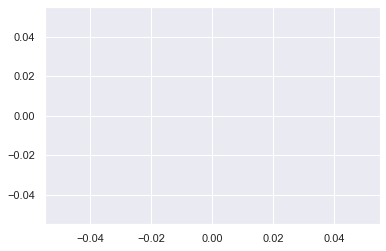

In [36]:
plt.plot(np.array(diff_sum_1[1:]).cumsum())
plt.plot(np.array(diff_sum_2[1:]).cumsum())

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


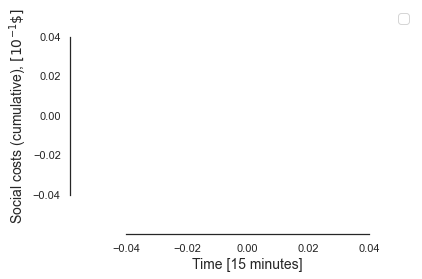

In [37]:
sns.set_style('white')
f, ax = plt.subplots()

df_1 = pd.DataFrame(np.array(res_1)[:, 0])
x = df_1.index

sns.lineplot(x = x[1:], y = np.array(diff_sum_1)[1:].cumsum(), label = 'Community 1, N = 25')
sns.lineplot(x = x[1:], y =np.array(diff_sum_2)[1:].cumsum(), label = 'Community 2, N = 5')

sns.lineplot(x = x, y=0, ls = ':', color = 'red')

sns.despine(offset=10, trim=True)

plt.xlabel("Time [15 minutes]", fontsize = 14)
plt.ylabel(r"Social costs (cumulative), $[10^{-1} \$]$", fontsize = 14)

ax.legend(fontsize = 13)

In [38]:
len(np.array(diff_1)[2:, 0].cumsum())

0

In [39]:
len(x)

1

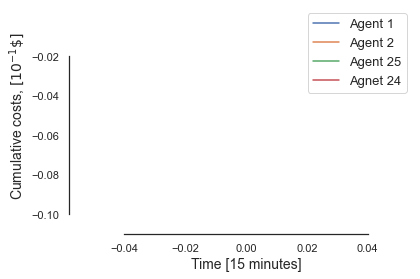

In [40]:
f, ax = plt.subplots()
#x = x[1:]

sns.lineplot(x = x, y = np.array(diff_1)[:, 0].cumsum(), label = 'Agent 1')
sns.lineplot(x = x, y =np.array(diff_1)[:, 1].cumsum(), label = 'Agent 2')

sns.lineplot(x = x, y = np.array(diff_1)[:, -1].cumsum(), label = 'Agent 25')
sns.lineplot(x = x, y= np.array(diff_1)[:, -2].cumsum(), label = 'Agnet 24')

sns.despine(offset=10, trim=True)
#sns.lineplot(x = x, y=np.array(diff_2)[:, 1].cumsum(), ls = ':', color = 'red', label = 'No forecast update')
sns.lineplot(x = x, y=0, ls = ':', color = 'red')

plt.xlabel("Time [15 minutes]", fontsize = 14)
plt.ylabel(r"Cumulative costs, $[10^{-1} \$]$", fontsize = 14)

ax.legend(fontsize = 13)

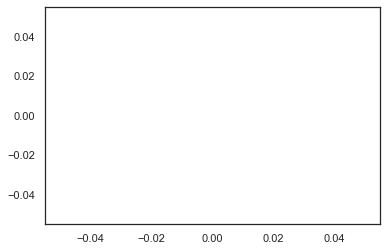

In [41]:
plt.plot(diff_sum_2[1:])

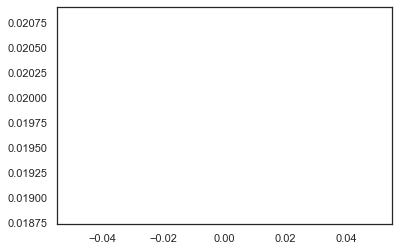

In [42]:
for i in range(4):
    plt.plot(np.array(prices_2[1]))

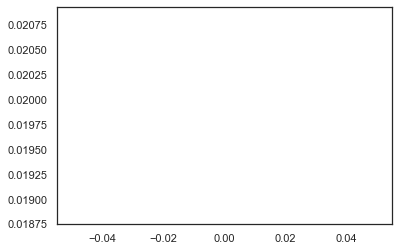

In [43]:
for i in range(4):
    plt.plot(prices_1[1])

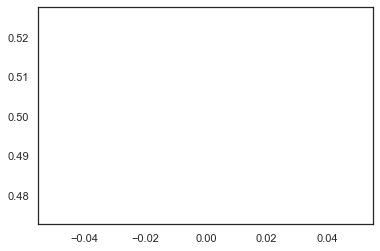

In [44]:
for i in range(4):
    plt.plot(prices_1[2])

In [45]:
diff_1

[array([-0.0126344 , -0.0401781 , -0.11131671, -0.94623119, -0.10053266,
        -0.09181677, -0.05265842, -0.08934948, -0.60482621, -0.58760259,
        -0.11555595, -0.73051167, -0.48266794, -0.16839405, -0.00429552,
        -2.830947  , -0.04648673, -0.15855402, -0.99328986, -0.06220051,
         0.07439296, -0.81184782, -0.05183725, -0.00785148, -0.10006805])]

In [46]:
diff_2

[array([-1.26343998e-02, -4.01780953e-02, -5.01289031e-01,  1.37970864e-04,
        -1.00532656e-01])]

In [47]:
trades_1

[{0: {'q_0_1': -10.0},
  1: {'q_1_0': 10.0, 'q_1_2': -10.0},
  2: {'q_2_1': 10.0, 'q_2_20': 7.21128963288902, 'q_2_24': -10.0},
  3: {'q_3_24': 10.0},
  4: {'q_4_15': 10.0, 'q_4_21': -10.0},
  5: {'q_5_22': 4.293502324227791},
  6: {'q_6_22': -10.0},
  7: {'q_7_14': -10.0},
  8: {'q_8_14': 10.0},
  9: {'q_9_16': 10.0},
  10: {'q_10_16': -5.46525625622304},
  11: {'q_11_17': 10.0},
  12: {'q_12_17': 10.0},
  13: {'q_13_19': 5.6679802788031814},
  14: {'q_14_7': 10.0, 'q_14_8': -10.0, 'q_14_15': -10.0},
  15: {'q_15_4': -10.0, 'q_15_14': 10.0, 'q_15_22': 10.0, 'q_15_24': 10.0},
  16: {'q_16_9': -10.0, 'q_16_10': 5.465256256223039, 'q_16_24': 10.0},
  17: {'q_17_11': -10.0, 'q_17_12': -10.0, 'q_17_19': -10.0},
  18: {'q_18_19': 10.0},
  19: {'q_19_13': -5.6679802788031814,
   'q_19_17': 10.0,
   'q_19_18': -10.0,
   'q_19_24': 10.0},
  20: {'q_20_2': -7.21128963288902},
  21: {'q_21_4': 10.0},
  22: {'q_22_5': -4.293502324227791,
   'q_22_6': 10.0,
   'q_22_15': -10.0,
   'q_22_23': 10.0}

In [48]:
trades_2

[{0: {'q_0_1': -10.0},
  1: {'q_1_0': 10.0, 'q_1_2': -10.0},
  2: {'q_2_1': 10.0},
  3: {},
  4: {}}]

In [49]:
res_1[0].sum()

54.49174939863396

In [50]:
res_2[0].sum()

11.273164664170725

In [51]:
model_1.getVars()

[<gurobi.Var Agent 0 day-ahead purchase (value 16.36107569568056)>,
 <gurobi.Var Agent 0 day-ahead sale (value 0.0)>,
 <gurobi.Var Agent 0 proba 0 real-time purchase (value 1.638912494654516)>,
 <gurobi.Var Agent 0 proba 1 real-time purchase (value 1.547861800507043)>,
 <gurobi.Var Agent 0 proba 2 real-time purchase (value 1.4568111063595701)>,
 <gurobi.Var Agent 0 proba 3 real-time purchase (value 1.3657604122120972)>,
 <gurobi.Var Agent 0 proba 4 real-time purchase (value 1.2747097180646243)>,
 <gurobi.Var Agent 0 proba 5 real-time purchase (value 1.1836590239171514)>,
 <gurobi.Var Agent 0 proba 6 real-time purchase (value 1.0926083297696785)>,
 <gurobi.Var Agent 0 proba 7 real-time purchase (value 1.0015576356222056)>,
 <gurobi.Var Agent 0 proba 8 real-time purchase (value 0.9105069414747327)>,
 <gurobi.Var Agent 0 proba 9 real-time purchase (value 0.8194562473272597)>,
 <gurobi.Var Agent 0 proba 10 real-time purchase (value 0.7284055531797868)>,
 <gurobi.Var Agent 0 proba 11 real-t

In [52]:
trades_2

[{0: {'q_0_1': -10.0},
  1: {'q_1_0': 10.0, 'q_1_2': -10.0},
  2: {'q_2_1': 10.0},
  3: {},
  4: {}}]

In [53]:
diff_trades = [[] for i in range(community_size)]
for agent in agents:
    for agent_2 in agents:
        if agent.connections[agent_2.id]:
            diff_trades[agent.id].append(trades_2[0][agent.id][f'q_{agent.id}_{agent_2.id}'] - trades_1[0][agent.id][f'q_{agent.id}_{agent_2.id}'])

diff_trades

KeyError: 'q_2_20'

In [ ]:
diff[1]

IndexError: list index out of range

In [ ]:
trades_1

[{0: {'q_0_1': -10.0},
  1: {'q_1_0': 10.0, 'q_1_2': -10.0},
  2: {'q_2_1': 10.0, 'q_2_20': 0.7144314469250101, 'q_2_24': -10.0},
  3: {'q_3_24': -0.42852525134383335},
  4: {'q_4_15': 10.0, 'q_4_21': -9.349966020460293},
  5: {'q_5_22': 2.0476253016486083},
  6: {'q_6_22': -10.0},
  7: {'q_7_14': -10.0},
  8: {'q_8_14': 1.6008825909987046},
  9: {'q_9_16': 10.0},
  10: {'q_10_16': 0.22927039923240145},
  11: {'q_11_17': 2.084261585530644},
  12: {'q_12_17': -0.28355600388136537},
  13: {'q_13_19': 2.320996498117715},
  14: {'q_14_7': 10.0, 'q_14_8': -1.6008825909987046, 'q_14_15': -10.0},
  15: {'q_15_4': -10.0,
   'q_15_14': 10.0,
   'q_15_22': 5.485449730371741,
   'q_15_24': -2.57530069053945},
  16: {'q_16_9': -10.0,
   'q_16_10': -0.22927039923240145,
   'q_16_24': 9.69452665545544},
  17: {'q_17_11': -2.0842615855306432,
   'q_17_12': 0.28355600388136537,
   'q_17_19': 3.283925502558242},
  18: {'q_18_19': 4.161168446130606},
  19: {'q_19_13': -2.3209964981177142,
   'q_19_17': 

In [ ]:
model_tso.getVars()

[<gurobi.Var Price for day-ahead purchase (value 0.3)>,
 <gurobi.Var Price for day-ahead sell (value 0.02)>,
 <gurobi.Var Price for real-time purchase (value 0.5)>,
 <gurobi.Var Price for real-time sell (value 0.01)>,
 <gurobi.Var Absolute value for community 0 (value 32.96637395587127)>]

In [ ]:
market_trades(agents, decision_vars)[1].sum()

-6.300193138407379

In [ ]:
np.array(decision_vars[0][f'Agent 0 rt_sale'])

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.05899022, 0.11798044,
       0.17697065, 0.23596087, 0.29495109, 0.35394131, 0.41293152,
       0.47192174, 0.53091196, 0.58990218, 0.64889239, 0.70788261,
       0.76687283, 0.82586305, 0.88485326, 0.94384348, 1.0028337 ,
       1.06182392, 1.12081414, 1.17980435, 1.23879457, 1.29778479,
       1.35677501, 1.41576522, 1.47475544, 1.53374566, 1.59273588,
       1.65172609, 1.71071631, 1.76970653, 1.82869675, 1.88768696,
       1.94667718, 2.0056674 , 2.06465762, 2.12364784, 2.18263805,
       2.24162827, 2.30061849, 2.35960871, 2.41859892, 2.47758914,
       2.53657936, 2.59556958, 2.65455979, 2.71355001, 2.77254

In [ ]:
sum(second_stage_resolution(model_1, agents, actual_generations, price_da_buy, price_da_sell, price_rt_buy, price_rt_sell)[0])

12.131044642696565

## Model with better forecasts for later

In [ ]:
#model with better forecasts

    #set the sellers of the forecasts
    sellers = []
    for id in range(community_size):
        probas, values = np.histogram(better_forecasts[id].rvs(size = 100000), bins = 100, density = True)
        probas = probas / probas.sum()
        sellers.append(Seller(probas, values, wager=1))

    #we don't need buyer on this stage, we set the buyer only to copmute qa_forecast
    buyer = Buyer(agents_forecasts[0][0],agents_forecasts[0][1], utility = 0)    

    task = actual_generations[0]
    market = Market(sellers, buyer, task = task)

    
    qa_forecast = market.aggregation(type= 'QA', plot = False)

    #setting the agents again
    agents = []
    for id in range(community_size):
        agent = Agents(id = id,
                    probabilities = agents_forecasts[id][0],
                    generation_values = agents_forecasts[id][1],
                    demand = demand[id],
                    connections = connection_matrix[id],
                    kappa = Kappa[id],
                    trading_cost=trading_costs)

        agents.append(agent)

    #those who purchase forecasts, update their information
    for id in range(community_size):
        if buys_forecast[id]:
            #probas, values = np.histogram(better_forecasts[id].rvs(size = 100000), bins = 100, density = True)
            probas, values = np.histogram(qa_forecast.rvs(size = 100000), bins = 100, density = True)
            probas = probas / probas.sum()
            agents[id].probabilities = probas
            agents[id].generation_values = values

    model_2 = gp.Model()

    market_2 = FirstStageMarket(agents= agents,
                                model = model_2,
                                price_da_buy = price_da_buy,
                                price_da_sell = price_da_sell,
                                price_rt_buy = price_rt_buy,
                                price_rt_sell = price_rt_sell)

    market_2.build_model()
    model_2.setParam('OutputFlag', 0)
    model_2.optimize()

    #Now we extract agents' decision variable values:
    decision_vars = extract_decision_variables(agents, model_2)
    trades_vars = extract_trades(agents, model_2)
    decisions_2.append(decision_vars)
    trades_2.append(trades_vars)

    #agent_0_trades_2[0].append(model_2.getVarByName(f'Agent {0} day-ahead purchase').X)
    #agent_0_trades_2[2].append(model_2.getVarByName(f'Agent {0} net trading').X)
    #agent_0_trades_2[1].append(model_2.getVarByName(f'Agent {0} day-ahead sale').X)

    res_2.append(overall_costs(agents, model_2,  price_da_buy, price_da_sell, price_rt_buy, price_rt_sell, actual_generations))

    diff_temp = overall_costs(agents, model_2,  price_da_buy, price_da_sell, price_rt_buy, price_rt_sell, actual_generations) - overall_costs(agents, model_1,  price_da_buy, price_da_sell, price_rt_buy, price_rt_sell, actual_generations)

    #now we compute the sellers' scores for the forecasts
    diff_reversed = - diff_temp

    temp_payoffs = compute_scores(sellers, agents_forecasts, agents, actual_generations, diff_reversed)[0]
    temp_scores = compute_scores(sellers, agents_forecasts, agents, actual_generations, diff_reversed)[1]

    sellers_payoffs_1.append(temp_payoffs)
    scores_1.append(temp_scores)

    diff.append(diff_temp)
    diff_sum.append(diff_temp.sum())

    da_trades, rt_trades = market_trades(agents, decision_vars)

    G_da = [da_trades.sum()]
    G_rt = [rt_trades.sum()]

    model_tso = gp.Model()

    tso = TSOOptimization(model_tso, G_da, G_rt, gamma, c_da_b, c_da_s, c_rt_b, c_rt_s)
    tso.build_model()

    model_tso.optimize()

    total_trade_2 = model_tso.getVarByName('Absolute value for community 0').X